In [29]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

In [30]:
# Dowload stock data 
# We consider the WANG portfoilo from Jim Cramers' Mad money.
data = yf.download('wmt nflx aapl goog', start="2017-01-01", end="2019-01-01")
data = data['Adj Close']
data.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,GOOG,NFLX,WMT
Date,,,,
2017-01-03,110.953873,786.140015,127.489998,64.080254
2017-01-04,110.829704,786.900024,129.410004,64.453575
2017-01-05,111.393303,794.020020,131.809998,64.593552
2017-01-06,112.635139,806.150024,131.070007,63.706921
2017-01-09,113.666824,806.650024,130.949997,64.126923


In [31]:
# calculate log returns
log_ret = np.log(data/data.shift(1))
log_ret = log_ret.dropna()
log_ret = log_ret.values

In [37]:
def simulate_portfolios(n_simulations, log_ret):
    
    # initialize some variables
    weights = np.zeros((n_simulations,log_ret.shape[1]))
    returns = np.zeros(n_simulations)
    volatility = np.zeros(n_simulations)
    sharp_ratio = np.zeros(n_simulations)

    for i in range(n_simulations):
        # simulate porfolios and calulate some statistics 
        weight = np.random.rand(4)
        weight = weight/np.sum(weight)
        weights[i] = weight
        returns[i] = np.sum(log_ret.mean(axis=0)*weight)*252
        volatility[i] = np.sqrt(weight.T.dot(np.cov(log_ret.T).dot(weight))) * np.sqrt(252)
        sharp_ratio[i] = returns[i]/volatility[i]
    return (weights,returns,volatility,sharp_ratio)

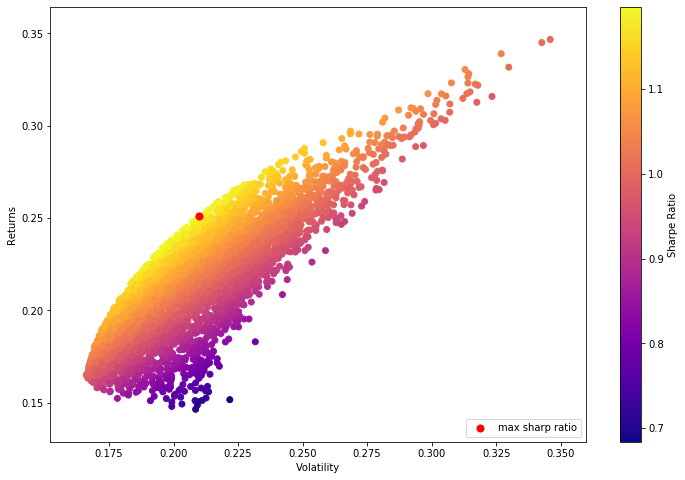

In [59]:
# plotting results
np.random.seed(69)
weights,returns,volatility,sharp_ratio = simulate_portfolios(n_simulations=5000, log_ret=log_ret)
plt.figure(figsize=(12,8))
plt.scatter(volatility,returns,c=sharp_ratio,cmap='plasma')
plt.colorbar(label = "Sharpe Ratio")
plt.scatter(volatility[sharp_ratio.argmax()],returns[sharp_ratio.argmax()],
            color = 'red',s=50,label = 'max sharp ratio')
plt.xlabel('Volatility')
plt.ylabel("Returns")
plt.legend(loc = 'lower right')
plt.show()

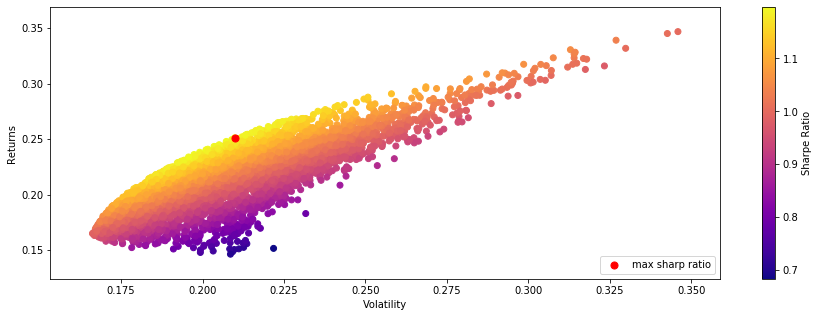

In [65]:
# cover photo
plt.figure(figsize=(15,5))
plt.scatter(volatility,returns,c=sharp_ratio,cmap='plasma')
plt.colorbar(label = "Sharpe Ratio")
plt.scatter(volatility[sharp_ratio.argmax()],returns[sharp_ratio.argmax()],
            color = 'red',s=50,label = 'max sharp ratio')
plt.xlabel('Volatility')
plt.ylabel("Returns")
plt.legend(loc = 'lower right')
plt.savefig('cover')
plt.show()


In [66]:
%timeit weights,returns,volatility,sharp_ratio = simulate_portfolios(n_simulations=10000, log_ret=log_ret)

786 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%prun weights,ret,vol,SR = simulate_portfolios(n_simulations=10000, log_ret=log_ret)

UsageError: Line magic function `%lprun` not found.


In [71]:
%load_ext line_profiler
%lprun -f simulate_portfolios weights,ret,vol,SR = simulate_portfolios(n_simulations=10000, log_ret=log_ret)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [50]:
# smart rewrite
def simulate_portfolios_s(n_simulations, log_ret):
    
    # initialize some variables
    weights = np.zeros((n_simulations,log_ret.shape[1]))
    returns = np.zeros(n_simulations)
    volatility = np.zeros(n_simulations)
    log_ret_mean = log_ret.mean(axis=0)
    cov_log_ret = np.cov(log_ret.T)
    
    for i in range(n_simulations):
        # simulate porfolios and calulate some statistics 
        weight = np.random.rand(4)
        weight = weight/np.sum(weight)
        weights[i] = weight
        returns[i] = np.sum(log_ret_mean*weight)*252
        volatility[i] = np.sqrt(weight.T.dot(cov_log_ret.dot(weight))) * np.sqrt(252)
    sharp_ratio = returns/volatility
    return (weights,returns,volatility,sharp_ratio)

In [51]:
%%timeit
weights,returns,volatility,sharp_ratio = simulate_portfolios_s(n_simulations=10000, log_ret=log_ret)

190 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
from numba import jit
@jit()
def simulate_portfolios_s_j(n_simulations, log_ret):
    
    # initialize some variables
    weights = np.zeros((n_simulations,log_ret.shape[1]))
    returns = np.zeros(n_simulations)
    volatility = np.zeros(n_simulations)
    log_ret_mean = log_ret.mean(axis=0)
    cov_log_ret = np.cov(log_ret.T)
    
    for i in range(n_simulations):
        # simulate porfolios and calulate some statistics 
        weight = np.random.rand(4)
        weight = weight/np.sum(weight)
        weights[i] = weight
        returns[i] = np.sum(log_ret_mean*weight)*252
        volatility[i] = np.sqrt(weight.T.dot(cov_log_ret.dot(weight))) * np.sqrt(252)
    sharp_ratio = returns/volatility
    return (weights,returns,volatility,sharp_ratio)

In [75]:
# first run of function compiles it to machine code
weights,returns,volatility,sharp_ratio = simulate_portfolios_s_j(n_simulations=10000, log_ret=log_ret)

In [74]:
%timeit weights,returns,volatility,sharp_ratio = simulate_portfolios_s_j(n_simulations=10000, log_ret=log_ret)

6.71 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%%timeit
weights,ret,vol,SR = simulate_portfolios_jit(n_simulations=500, log_ret=log_ret)

6.68 ms ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
from numba import jit, prange
@jit(nopython=True,parallel=True)
def simulate_portfolios_s_j_p(n_simulations, log_ret):
    
    # initialize some variables
    weights = np.zeros((n_simulations,log_ret.shape[1]))
    returns = np.zeros(n_simulations)
    volatility = np.zeros(n_simulations)
    log_ret_mean = log_ret.mean(axis=0)
    cov_log_ret = np.cov(log_ret.T)
    
    for i in prange(n_simulations):
        # simulate porfolios and calulate some statistics 
        weight = np.random.rand(4)
        weight = weight/np.sum(weight)
        weights[i] = weight
        returns[i] = np.sum(log_ret_mean*weight)*252
        volatility[i] = np.sqrt(weight.T.dot(cov_log_ret.dot(weight))) * np.sqrt(252)
    sharp_ratio = returns/volatility
    return (weights,returns,volatility,sharp_ratio)

In [80]:
# first run of function compiles it to machine code
weights,returns,volatility,sharp_ratio = simulate_portfolios_s_j(n_simulations=10000, log_ret=log_ret)

In [82]:
%timeit weights,returns,volatility,sharp_ratio = simulate_portfolios_s_j(n_simulations=10000, log_ret=log_ret)

6.73 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
